In this problem, you will train a neural network to classify satellite images. In the data/EuroSAT_RGB directory, you will find 11 subdirectories, each corresponding to a different class of land or land use: e.g. industrial, crops, rivers, forest, etc. Within each subdirectory, you will find examples in .jpg format of each type. (Thus the name of the directory in which the image lives is the class label.)

Your job is to set up a neural network that can classify the images as accurately as possible. Use an 80/20 train test split. Summarize your model and its accuracy in any way you see fit, but make you include at a minimum the following elements:

overall test-set accuracy, measured however you think is appropriate
show some of the example images from the test set, together with your model's predicted classes.
a confusion matrix showing the performance of the model on the set test, i.e. a table that cross-tabulates each test set example by (actual class, predicted class).
I strongly recommend the use of PyTorch in a Jupyter notebook for this problem; look into PyTorch's ImageFolder data set class, which will streamline things considerably.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

## Model Building

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to a uniform size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset = datasets.ImageFolder('data/EuroSAT_RGB', transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 11)  # 11 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')


Epoch 1, Loss: 0.9906805215941535
Epoch 2, Loss: 0.6268996080866567
Epoch 3, Loss: 0.47184293589106313
Epoch 4, Loss: 0.3270282294683986
Epoch 5, Loss: 0.23147618603927117
Epoch 6, Loss: 0.1621929427129389
Epoch 7, Loss: 0.1175200838205853
Epoch 8, Loss: 0.08720591231128545
Epoch 9, Loss: 0.08890518515267305
Epoch 10, Loss: 0.07487312584882602


In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test set accuracy: {accuracy*100:.2f}')





Test set accuracy: 84.26


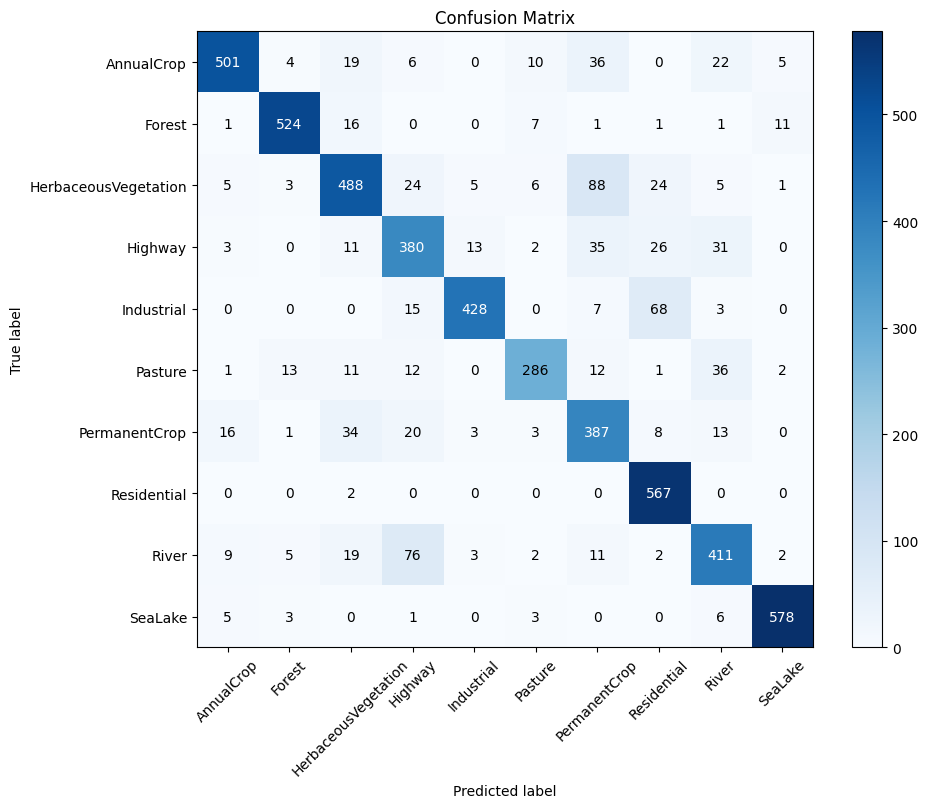

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assume all_preds and all_labels are already defined
cm = confusion_matrix(all_labels, all_preds)
classes = dataset.classes  # This will give you the class names from the ImageFolder

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

# Add numbers to each cell
thresh = cm.max() / 2.  # Threshold for color change in text
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

# Set class labels on axes
plt.xticks(np.arange(len(classes)), classes, rotation=90)
plt.yticks(np.arange(len(classes)), classes)

# Add axis labels
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


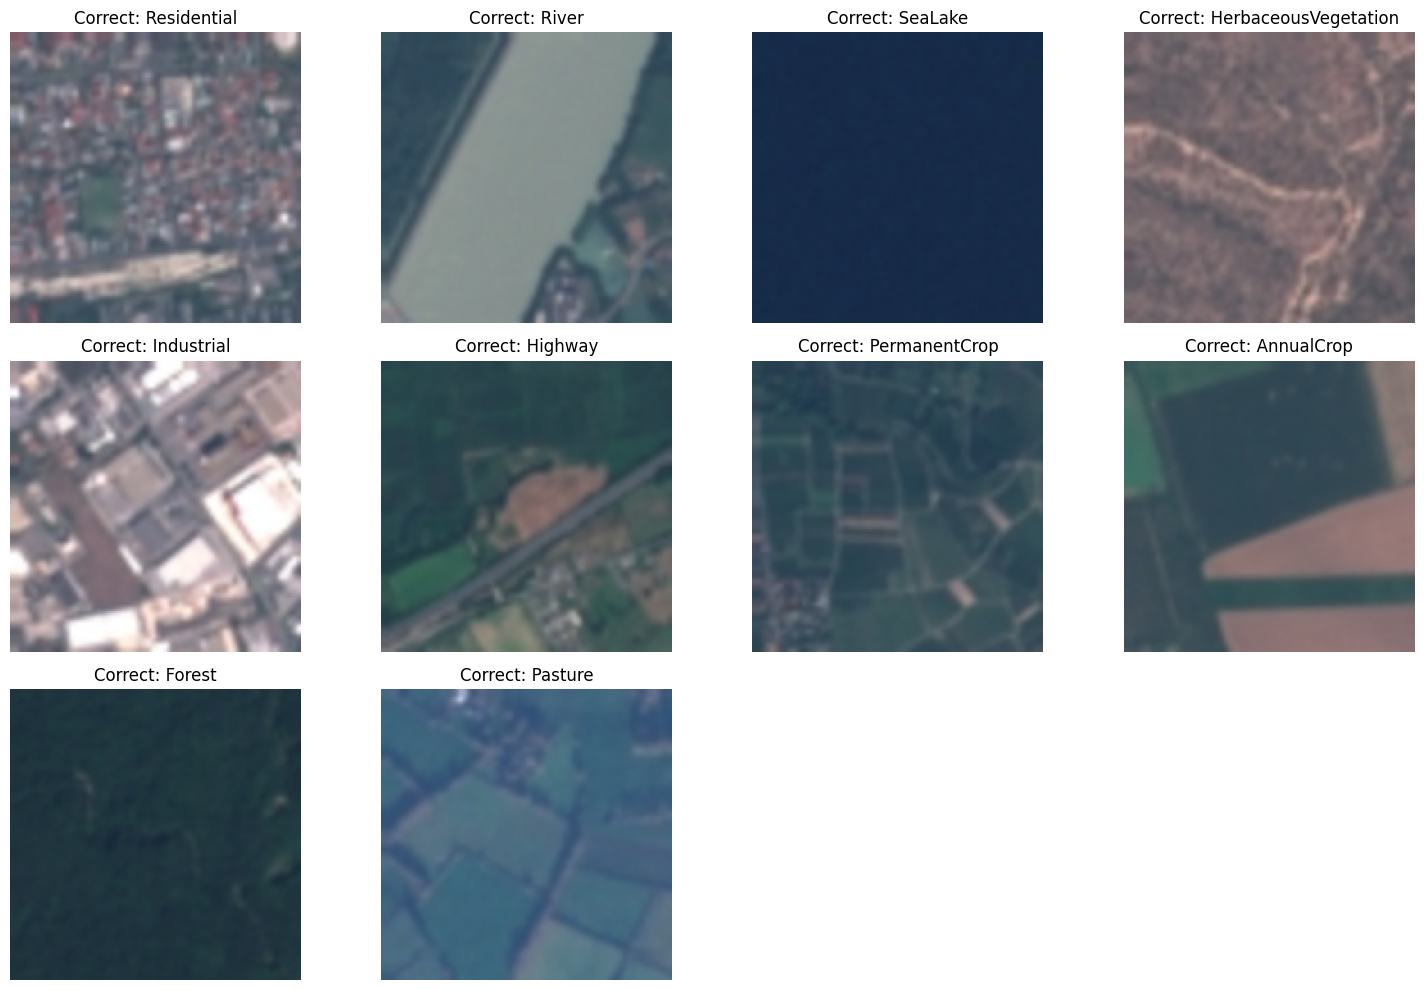

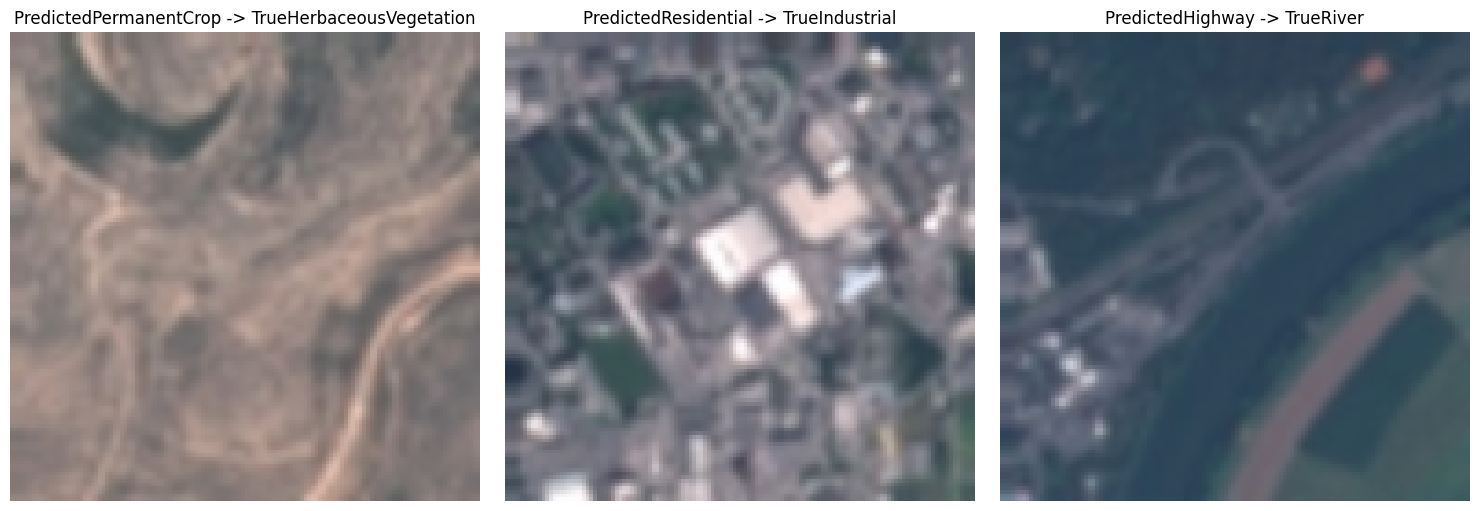

In [17]:
import matplotlib.pyplot as plt
import numpy as np


correct_per_class = {}
incorrect_cases = {}

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        for i in range(len(labels)):
            true_label = labels[i].item()
            predicted_label = preds[i].item()
            image = images[i].cpu().numpy().transpose(1, 2, 0)  
            image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  
            image = np.clip(image, 0, 1)
            
            
            if true_label == predicted_label and true_label not in correct_per_class:
                correct_per_class[true_label] = image
            
            ## these are just interesting cases I wanted to check based on the confusion matrix
            if true_label == dataset.class_to_idx['HerbaceousVegetation'] and predicted_label == dataset.class_to_idx['PermanentCrop']:
                incorrect_cases['PredictedPermanentCrop_TrueHerbaceousVegetation'] = image
            elif true_label == dataset.class_to_idx['River'] and predicted_label == dataset.class_to_idx['Highway']:
                incorrect_cases['PredictedHighway_TrueRiver'] = image
            elif true_label == dataset.class_to_idx['Industrial'] and predicted_label == dataset.class_to_idx['Residential']:
                incorrect_cases['PredictedResidential_TrueIndustrial'] = image
            
            
            if len(correct_per_class) == len(classes) and len(incorrect_cases) >= 3:
                break


plt.figure(figsize=(15, 10))
for idx, (class_idx, image) in enumerate(correct_per_class.items()):
    plt.subplot(3, 4, idx + 1)
    plt.imshow(image)
    plt.title(f"Correct: {classes[class_idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


num_incorrect_cases = len(incorrect_cases)
num_cols = min(num_incorrect_cases, 3)  
num_rows = (num_incorrect_cases + num_cols - 1) // num_cols  

plt.figure(figsize=(15, 5 * num_rows))
for idx, (description, image) in enumerate(incorrect_cases.items()):
    plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(image)
    plt.title(description.replace('_', ' -> '))
    plt.axis('off')

plt.tight_layout()
plt.show()
